<a href="https://colab.research.google.com/github/DerekZ66/ALY6110/blob/main/ALY6110_Final_Team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Running Hive on Pyspark in Colab**

Prepare PySpark Cluster

In [2]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

#Run a local spark session to test your installation:

In [ ]:
# install findspark using pip
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()


# Upload Data to Working Directory

In [ ]:
from google.colab import files
files.upload()

In [5]:
import pylab as pl
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col,isnan, when, count
import pyspark.sql.functions as F
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Load Data to Spark Cluster

In [7]:
df = spark.read.csv('housing.csv',inferSchema=True, header =True)

# Data processing and EDA

In [8]:
# EDA
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|       8.3252|            452600|       NEAR BAY|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138|       8.3014|            358500|       NEAR BAY|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|       7.2574|            352100|       NEAR BAY|
|  -122.25|   37.85|                52|       1274|           235|       558|       219|       5.6431|            341300|       NEAR BAY|
|  -122.25|   37.85|              

In [9]:
# EDA
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: integer (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [10]:
# EDA
df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           null|
| stddev|  2.0035317

In [11]:
# show null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [12]:
# multiple median_income by 10000 to standarize the monetory amount
df = df.withColumn("median_income", df["median_income"] * 10000)

In [13]:
# fill null values with mean
total_bedrooms_mean = df.select(F.mean('total_bedrooms')).collect()[0][0]
df.fillna(value = total_bedrooms_mean)
df=df.na.fill(value=total_bedrooms_mean, subset=["total_bedrooms"])

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [14]:
# factorize ocean_proximity
ocean_proximity_factor = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_type")
df = ocean_proximity_factor.fit(df).transform(df)
df.show()
df.select("ocean_proximity", "ocean_proximity_type").distinct().show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|ocean_proximity_type|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|       NEAR BAY|                 3.0|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|       NEAR BAY|                 3.0|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100|       NEAR BAY|                 3.0|
|  -122.25|   37

In [15]:
df = df.drop("ocean_proximity")
df = df.withColumnRenamed("ocean_proximity_type", "ocean_proximity")
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|            3.0|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|            3.0|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100|            3.0|
|  -122.25|   37.85|                52|       1274|           235|       558|       219| 56430.99999999999|            341300|            3.0|

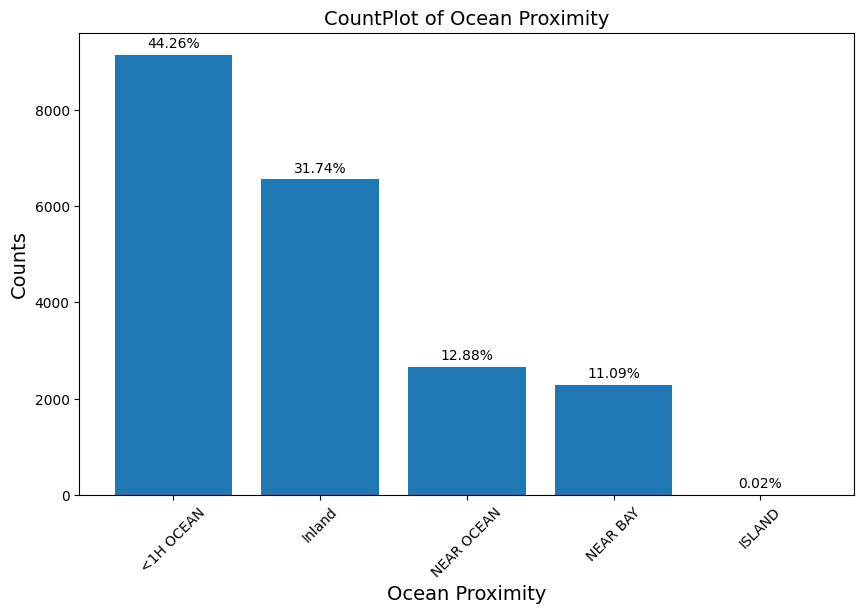

In [66]:
from pyspark.sql.functions import expr
ocean_proximity_counts = df.groupBy("ocean_proximity").agg(count("*").alias("count"))

# Calculate the total count for percentage calculation
total_count = ocean_proximity_counts.agg(expr("sum(count)").alias("total_count")).collect()[0]["total_count"]

# Calculate the percentage and add it as a new column
ocean_proximity_counts = ocean_proximity_counts.withColumn("percentage", (ocean_proximity_counts["count"] / total_count) * 100)

# Sort the DataFrame by "percentage"
ocean_proximity_counts = ocean_proximity_counts.orderBy("percentage")

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(ocean_proximity_counts.select("ocean_proximity").rdd.flatMap(lambda x: x).collect(),
              ocean_proximity_counts.select("count").rdd.flatMap(lambda x: x).collect())
plt.title('CountPlot of Ocean Proximity', fontsize=14, c='k')
plt.xlabel('Ocean Proximity', fontsize=14, c='k')
plt.ylabel('Counts', fontsize=14, c='k')
plt.xticks(range(len(ocean_values["ocean_proximity"])), ["<1H OCEAN", "Inland", "NEAR OCEAN", "NEAR BAY", "ISLAND"], rotation=45)

# Annotate the bars with percentage values
for bar, percentage in zip(bars, ocean_proximity_counts.select("percentage").rdd.flatMap(lambda x: x).collect()):
    height = bar.get_height()
    plt.annotate(f'{percentage:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

plt.show()

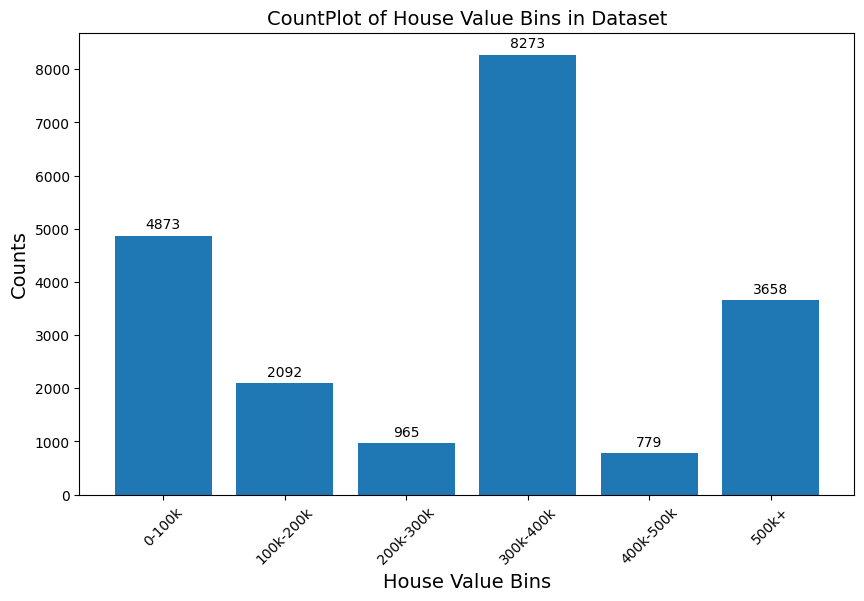

In [63]:
bin_boundaries = [0, 100000, 200000, 300000, 400000, 500000, float('inf')]

# Create a column with custom bins based on the "median_house_value" column
df_with_bins = df.withColumn(
    "house_value_bins",
    when(col("median_house_value") <= 100000, "0-100k")
    .when(col("median_house_value") <= 200000, "100k-200k")
    .when(col("median_house_value") <= 300000, "200k-300k")
    .when(col("median_house_value") <= 400000, "300k-400k")
    .when(col("median_house_value") <= 500000, "400k-500k")
    .otherwise("500k+")
)

# Group by the custom bins and count occurrences
house_value_counts = df_with_bins.groupBy("house_value_bins").count()

# Define the order of custom bins for x-axis labels
custom_order = [
    "0-100k",
    "100k-200k",
    "200k-300k",
    "300k-400k",
    "400k-500k",
    "500k+"
]

plt.figure(figsize=(10, 6))
bars = plt.bar(custom_order, house_value_counts.select("count").rdd.flatMap(lambda x: x).collect())
plt.title('CountPlot of House Value Bins in Dataset', fontsize=14, c='k')
plt.xlabel('House Value Bins', fontsize=14, c='k')
plt.ylabel('Counts', fontsize=14, c='k')
plt.xticks(rotation=45)

# Add count values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

plt.show()

# Clustering

In [16]:
# clustering
input_features = [col for col in df.columns if col not in ['longitude', 'latitude']]
assembler = VectorAssembler(inputCols = input_features, outputCol='features')
assembled_df = assembler.transform(df)
assembled_df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|            features|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|            3.0|[41.0,880.0,129.0...|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|            3.0|[21.0,7099.0,1106...|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100|            3.0|[52.0,1467.0,190....|
|  -122.25|   37

In [17]:
# perform elbow method to find optimal number of clusters

# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(100).setFeaturesCol('features')
    model = kmeans.fit(assembled_df)
    cost[k] = model.summary.trainingCost


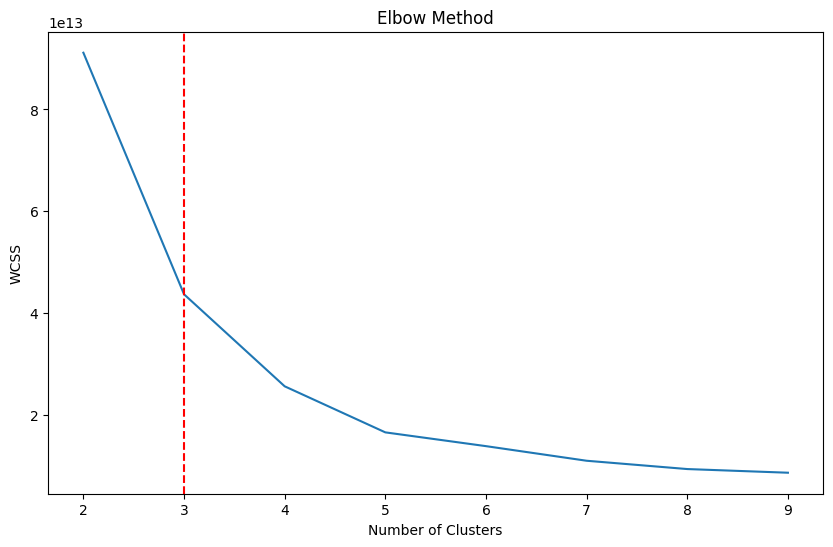

In [18]:
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = list(range(2,10))
df_cost.insert(0, 'cluster', new_col)

pl.figure(figsize=(10,6))
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('WCSS')
pl.title('Elbow Method')
pl.axvline(x=3, color='red', linestyle='--')

In [19]:
#based on elbow - 3 clusters
kmeans_3 = KMeans(featuresCol="features",k=3)
model_3 = kmeans_3.fit(assembled_df)
model_3

KMeansModel: uid=KMeans_5884ebaa36e3, k=3, distanceMeasure=euclidean, numFeatures=8

In [20]:
#show counts based on pred
model_3.transform(assembled_df).groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3059|
|         2| 7311|
|         0|10270|
+----------+-----+



In [21]:
predictions =model_3.transform(assembled_df)
predictions.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|            features|prediction|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+----------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|            3.0|[41.0,880.0,129.0...|         1|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|            3.0|[21.0,7099.0,1106...|         1|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100

In [22]:
housingclustering = predictions.drop(col("features"))
housingclustering.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-----------------+------------------+---------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|    median_income|median_house_value|ocean_proximity|prediction|
+---------+--------+------------------+-----------+--------------+----------+----------+-----------------+------------------+---------------+----------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|          83252.0|            452600|            3.0|         1|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138|83013.99999999999|            358500|            3.0|         1|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|          72574.0|            352100|            3.0|         1|
|  -122.25|   37.85|                52|       1274|           235|       558|     

In [23]:
# Define the columns for which you want to calculate statistics
columns_to_drop = ["longitude", "latitude", "ocean_proximity","features"]
housingclustering_stat = predictions.drop(*columns_to_drop)
housingclustering_stat.show()

+------------------+-----------+--------------+----------+----------+------------------+------------------+----------+
|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|prediction|
+------------------+-----------+--------------+----------+----------+------------------+------------------+----------+
|                41|        880|           129|       322|       126|           83252.0|            452600|         1|
|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|         1|
|                52|       1467|           190|       496|       177|           72574.0|            352100|         1|
|                52|       1274|           235|       558|       219| 56430.99999999999|            341300|         1|
|                52|       1627|           280|       565|       259|           38462.0|            342200|         1|
|                52|        919|           213| 

In [24]:
# calculate the statistics based on pred
cluster_stats = predictions.groupBy("prediction").agg(
    F.count("*").alias("count"),

    #F.mean("housing_median_age").alias("mean_housing_median_age"),
    #F.stddev_pop("housing_median_age").alias("stddev_housing_median_age"),
    #F.min("housing_median_age").alias("min_housing_median_age"),
    #F.max("housing_median_age").alias("max_housing_median_age"),

    #F.mean("total_rooms").alias("mean_total_rooms"),
    #F.stddev_pop("total_rooms").alias("stddev_total_rooms"),
    #F.min("total_rooms").alias("min_total_rooms"),
    #F.max("total_rooms").alias("max_total_rooms"),

    #F.mean("total_bedrooms").alias("mean_total_bedrooms"),
    #F.stddev_pop("total_bedrooms").alias("stddev_total_bedrooms"),
    #F.min("total_bedrooms").alias("min_total_bedrooms"),
    #F.max("total_bedrooms").alias("max_total_bedrooms"),

    #F.mean("population").alias("mean_population"),
    #F.stddev_pop("population").alias("stddev_population"),
    #F.min("population").alias("min_population"),
    #F.max("population").alias("max_population"),

    #F.mean("households").alias("mean_households"),
    #F.stddev_pop("households").alias("stddev_households"),
    #F.min("households").alias("min_households"),
    #F.max("households").alias("max_households"),

    F.mean("median_income").alias("mean_median_income"),
    F.stddev_pop("median_income").alias("stddev_median_income"),
    #F.min("median_income").alias("min_median_income"),
    #F.max("median_income").alias("max_median_income"),

    F.mean("median_house_value").alias("mean_median_house_value"),
    F.stddev_pop("median_house_value").alias("stddev_median_house_value"),
    #F.min("median_house_value").alias("min_median_house_value"),
    #F.max("median_house_value").alias("max_median_house_value")
)

cluster_stats.show()

+----------+-----+------------------+--------------------+-----------------------+-------------------------+
|prediction|count|mean_median_income|stddev_median_income|mean_median_house_value|stddev_median_house_value|
+----------+-----+------------------+--------------------+-----------------------+-------------------------+
|         1| 3059|62854.915985616215|  26270.322829864373|     426279.36090225563|        62838.35380063539|
|         2| 7311| 42700.41075092326|   13284.17929317801|     239571.28983723157|        41856.47818358698|
|         0|10270| 28670.94488802337|  10411.335371638022|     118209.32775073028|        37099.03742159418|
+----------+-----+------------------+--------------------+-----------------------+-------------------------+



In [25]:
vis_df = predictions.toPandas()
# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='median_house_value', y='median_income', z='households', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 1)
fig.update_layout(width=800, height=600)
fig.show()

#cluster 2: high house value, high income
#cluster 1: middle house value, middle income
#cluster 0：low house value, low income

In [26]:
# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='median_house_value', y='median_income', z='housing_median_age', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 1)
fig.update_layout(width=800, height=600)
fig.show()


In [27]:
# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='median_house_value', y='median_income', z='total_rooms', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 1)
fig.update_layout(width=800, height=600)
fig.show()


In [28]:
fig = px.scatter_3d(vis_df, z='median_house_value', x='longitude', y='latitude', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 2)
fig.update_layout(width=800, height=600)
fig.show()

# Regression

In [29]:
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|           83252.0|            452600|            3.0|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138| 83013.99999999999|            358500|            3.0|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|           72574.0|            352100|            3.0|
|  -122.25|   37.85|                52|       1274|           235|       558|       219| 56430.99999999999|            341300|            3.0|

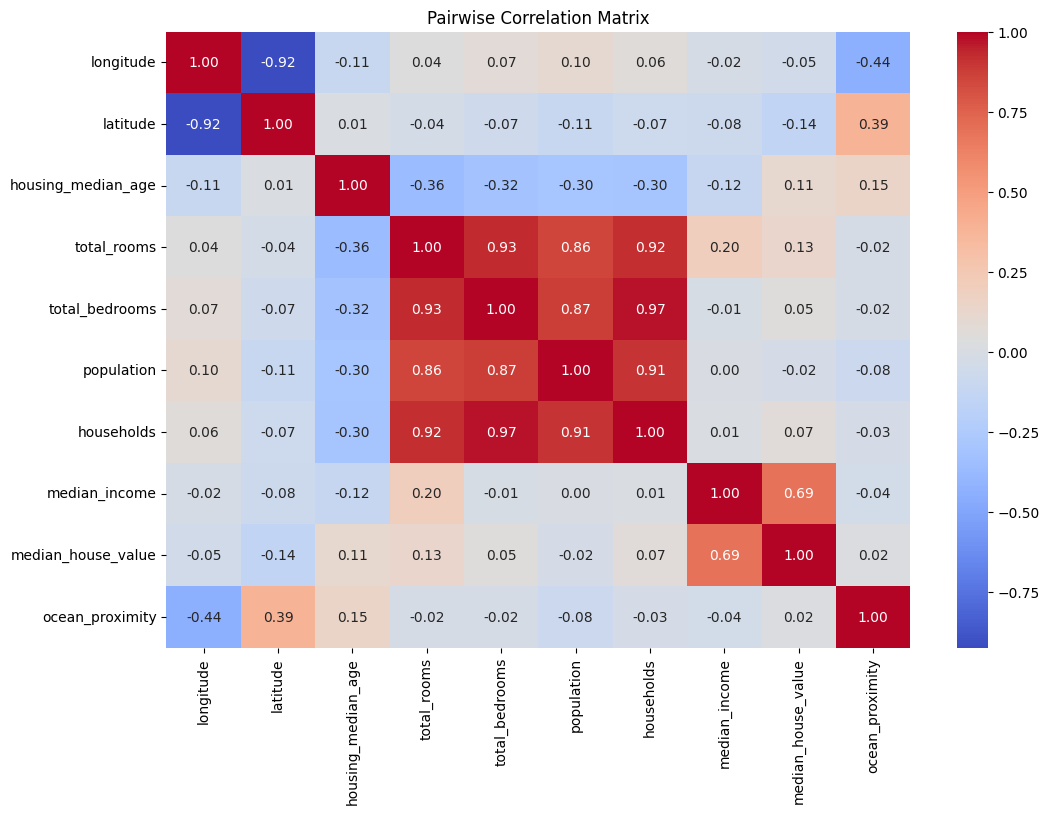

In [30]:
# Calculate the pairwise correlation matrix
correlation_matrix = df.toPandas().corr()

# Plot the correlation heatmap with correlation valuss as annotations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Pairwise Correlation Matrix')
plt.show()

In [31]:
only_features = ['households','population','total_bedrooms','median_income','total_rooms','housing_median_age','ocean_proximity']

# vectorize the features
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
assembled_df = assembler.transform(df)

# feature scaling
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

# inspect the result
scaled_df.select("features", "features_scaled").show(5, truncate=False)

+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|features                                                |features_scaled                                                                                                                        |
+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|[126.0,322.0,129.0,83252.0,880.0,41.0,3.0]              |[0.3295584480852433,0.2843362208866199,0.30768012429380304,4.382095394195218,0.40337085073160667,3.2577023016083064,2.9864139366491074]|
|[1138.0,2401.0,1106.0,83013.99999999999,7099.0,21.0,3.0]|[2.9764882057222772,2.1201592122632746,2.6379396703019085,4.369567902917909,3.2540109878905406,1.668579227653035,2.9864139366491074]   |
|[177.0,496.0,190.0,72574

In [32]:
import pprint
# split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=1000)

# Create a Linear Regression Estimator
lr = LinearRegression(featuresCol="features_scaled", labelCol="median_house_value")
lr_model = lr.fit(train_data)

coefficients = lr_model.coefficients

intercept = lr_model.intercept

# Print the coefficients with the name of the features
print("Model - Multivariable Linear Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, lr_model.coefficients)))
print("Intercept: %f" %intercept)


# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
predictions = lr_model.evaluate(test_data)


rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(predictions.predictions))
print("r2: %f \n" % r2_evaluator.evaluate(predictions.predictions))

Model - Multivariable Linear Regression
Coefficients:
{'households': 54786.826233238105,
 'housing_median_age': 23814.95406992098,
 'median_income': 89656.73375532494,
 'ocean_proximity': 969.742803860717,
 'population': -39896.31014951316,
 'total_bedrooms': 33077.57724957307,
 'total_rooms': -40377.54900695925}
Intercept: -45780.743314
Performance of the model on the training data:
RMSE: 76407.100955
r2: 0.557089 

Performance of the model on the testing data:
RMSE: 74641.700898
r2: 0.597944 



# Lasso Regression

In [33]:
# perform lasso regression
lasso_regression = LinearRegression(featuresCol='features_scaled', labelCol="median_house_value",  elasticNetParam=1, maxIter=10)
linearModel = lasso_regression.fit(train_data)

# Print the coefficients with the name of the features
print("Model - LASSO Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, linearModel.coefficients)))
print("Intercept: %s \n" % str(linearModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = linearModel.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
ls_predictions = linearModel.transform(test_data)

# Summarize the model over the testing set and print out some metrics
rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(ls_predictions))
print("r2: %f \n" % r2_evaluator.evaluate(ls_predictions))

Model - LASSO Regression
Coefficients:
{'households': 54786.826233238105,
 'housing_median_age': 23814.95406992098,
 'median_income': 89656.73375532494,
 'ocean_proximity': 969.742803860717,
 'population': -39896.31014951316,
 'total_bedrooms': 33077.57724957307,
 'total_rooms': -40377.54900695925}
Intercept: -45780.74331391428 

Performance of the model on the training data:
RMSE: 76407.100955
r2: 0.557089 

Performance of the model on the testing data:
RMSE: 74641.700898
r2: 0.597944 



# Random Forest

In [67]:
from pyspark.ml.regression import RandomForestRegressor
# Create a RandomForestRegressor model
rf = RandomForestRegressor(labelCol="median_house_value", numTrees=100, maxDepth=4)

# Split the data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2],seed=1000)

# Fit the Random Forest model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest model using appropriate metrics (e.g., RMSE or MAE)
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)

evaluator_mae = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(rf_predictions)


print("Random Forest RMSE:", rmse)
print("Random Forest MAE:", mae)

Random Forest RMSE: 72022.01816430781
Random Forest MAE: 54180.42998249223


In [68]:
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(rf_predictions)

print("Random Forest R-squared (R2):", r_squared)

Random Forest R-squared (R2): 0.6256705175061499


In [69]:
feature_importances = rf_model.featureImportances

In [70]:
# input_features = assembled_df.getInputCols()
only_features

['households',
 'population',
 'total_bedrooms',
 'median_income',
 'total_rooms',
 'housing_median_age',
 'ocean_proximity']

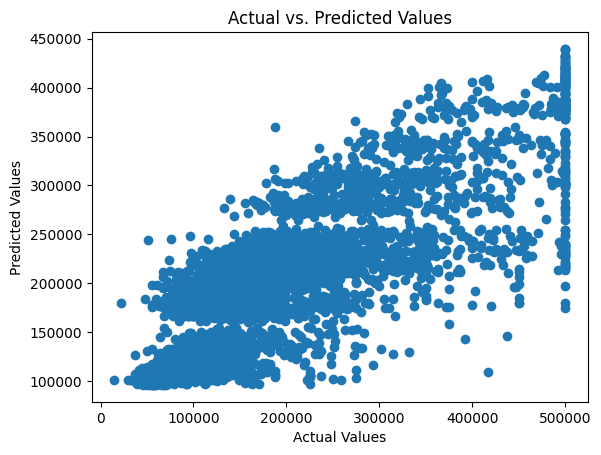

In [71]:
# Assuming you have a Pandas DataFrame with actual and predicted values
actual = test_data.select("median_house_value").toPandas()
predicted = rf_predictions.select("prediction").toPandas()

plt.scatter(actual, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

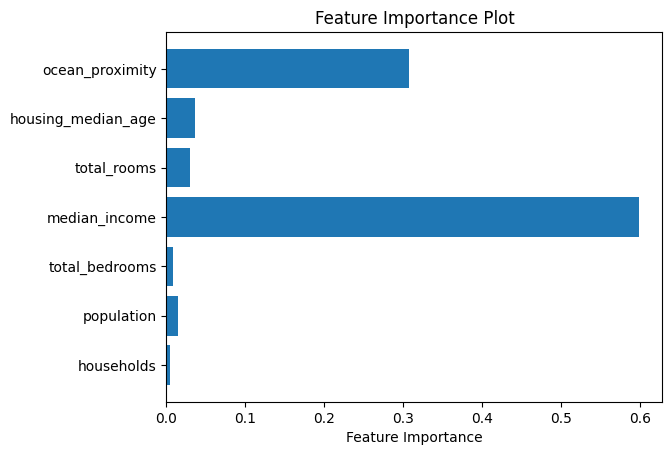

In [72]:
importances = feature_importances.toArray()
indices = range(len(importances))

plt.barh(indices, importances, align="center")
plt.yticks(indices, only_features)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

In [ ]:
importances

In [ ]:
#spark.stop()